**Importing** **Libraries**

In [39]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # for Standardization
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.svm import SVC  # for classification
from sklearn.model_selection import GridSearchCV
from sklearn import svm

**Loading Dataset CIFAR10**

In [40]:
cifar10 = tf.keras.datasets.cifar10
(X, y), (X_test, y_test) = cifar10.load_data() # load cifar10

**Split Data Process**

Επειδή ο διαχωρισμός των δεδομένων σε train-test γίνεται αυτόματα σε 90%-10% χρησιμοποιώ την μέθοδο concatenate(), ώστε να ενοποιήσω τα εκπαίδευσης - δοκιμής και στη συνέχεια τα ξαναχωρίζω σε train-test με ποσοστά 60%-40%.

**Επιλέγω τυχαία ένα υποσύνολο του συνολικού dataset cifar10.

In [41]:
# combine train and test dataset
X_full = np.concatenate((X, X_test), axis=0)
y_full = np.concatenate((y, y_test), axis=0)

# select a random subset
subset_size = 1000
indices = np.random.choice(len(X_full), size=subset_size, replace=False)
X_full = X_full[indices]
y_full = y_full[indices]

# Split data into train-validation-test sets (60%-30%-10%)
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.4,
                                                    random_state=0)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.75,
                                                random_state=0)

**Data** **Preprocessing**

Εαν εμφανίσουμε το σχήμα των δεδομένων εκπαίδευσης - δοκιμής με την μέθοδο
shape() βλέπουμε τις 4 διαστάσεις του πίνακα που περιέχει τις εικόνες.

1. Για τα δεδομένα εκπαίδευσης: Η πρώτη διάσταση δείχνει τον αριθμώ των εικόνων, η δεύτερη και η τρίτη το ύψος και το πλάτος των εικόνων σε pixel και η τέταρτη τον αριθμό των καναλιών χρώματος (RGB).

2. Για τα δεδομένα δοκιμής: Η πρώτη διάσταση δείχνει τον αριθμώ των εικόνων και η δεύτερη ότι για κάθε εικόνα αντιστοιχεί ένα label δηλαδή μία κατηγορία που αναπαριστά κάθε εικόνα.

In [42]:
print("X_train.shape: {}\ny_train.shape: {}\nX_test.shape: {}\ny_test.shape: {}\nX_val.shape: {}\ny_val.shape: {}".format(X_train.shape, y_train.shape,
                                                                                                                          X_test.shape, y_test.shape,
                                                                                                                          X_val.shape, y_val.shape))

X_train.shape: (600, 32, 32, 3)
y_train.shape: (600, 1)
X_test.shape: (300, 32, 32, 3)
y_test.shape: (300, 1)
X_val.shape: (100, 32, 32, 3)
y_val.shape: (100, 1)


Ο SVM δεν μπορεί να επεξεργαστεί δεδομένα εικόνας απευθείας σε μορφή πίνακα 2D ή 3D. Επομένως, για να μπορέσει να δεχθεί τις εικόνες ως δεδομένα εισόδου και να ακολουθήσει η διαδικασία εκπαίδευσης - δοκιμής θα πρέπει πρώτα να γίνει μετατροπή (reshape()) των δεδομένων σε μονοδιάστατα διανύσματα (flat vectors).


In [43]:
# Reshaping Data into vectors
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

print("X_train.shape: {}\ny_train.shape: {}\nX_test.shape: {}\ny_test.shape: {}\nX_val.shape: {}\ny_val.shape: {}".format(X_train.shape, y_train.shape,
                                                                                                                          X_test.shape, y_test.shape,
                                                                                                                          X_val.shape, y_val.shape))

X_train.shape: (600, 3072)
y_train.shape: (600, 1)
X_test.shape: (300, 3072)
y_test.shape: (300, 1)
X_val.shape: (100, 3072)
y_val.shape: (100, 1)


Για τη βελτίωση της απόδοσης του SVM είναι απαραίτητες η "Κανονικοποίηση" των δεδομένων και η "Μέθοδος Ανάλυσης Κύριων Συνιστωσών" (PCA).

Κάνουμε κανονικοποίηση για να εξασφαλίσουμε ότι όλα τα χαρακτηρισιτκά έχουν την ίδια κλίμακα, έτσι ώστε να μην κυριαρχούν χαρακτηριστικά σε μεγάλες τιμές στην pca.

Με το PCA επιτυγχάνεται η μείωση διάστασης των δεδομένων κρατώντας τις πιο σημαντικές συνιστώσες δηλαδή επιτυγχάνεται η αναδόμηση των δεδομένων σε νέες διαστάσεις.

In [44]:
# Standardization of data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [ ]:
# Normalization
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

In [45]:
# pca for dimensionality reduction
pca_cifar = PCA(n_components=50)
X_train = pca_cifar.fit_transform(X_train)
X_test = pca_cifar.transform(X_test)
X_val = pca_cifar.transform(X_val)

print("X_train.shape: {}\ny_train.shape: {}\nX_test.shape: {}\ny_test.shape: {}\nX_val.shape: {}\ny_val.shape: {}".format(X_train.shape, y_train.shape,
                                                                                                                          X_test.shape, y_test.shape,
                                                                                                                          X_val.shape, y_val.shape))

X_train.shape: (600, 50)
y_train.shape: (600, 1)
X_test.shape: (300, 50)
y_test.shape: (300, 1)
X_val.shape: (100, 50)
y_val.shape: (100, 1)


**Model** **Training**

Types of Kernel: Linear, RBF, Polynomial

SVM Linear Kernel

Δοκιμάζω διαφορετικές τιμές της παραμέτρου C (regularization parameter).
Δημιουργία μεθόδου linear_model_method (), η οποία θα παίρνει ως όρισμα διαφορετικές παραμέτρους C από μία λίστα που θα δημιουργήσω.

In [46]:
# Prepare variables to store the results
train_set_accuracy = []
val_set_caccuracy = []
test_set_accuracy = []
results = []

# Function to train SVM with Linear Kernel
def linear_model_SVM (c):
    start_time = time.time()
    svm_classifier = SVC(kernel='linear', C=c)

    svm_classifier.fit(X_train, y_train.ravel())

    # Accuracy for train set
    pred = svm_classifier.predict(X_train)
    acc_train = np.mean(pred == y_train.ravel())
    train_set_accuracy.append(acc_train)
    print("Train Accuracy for C = {}: {}".format(c, acc_train))

    # Accuracy for validation set
    pred = svm_classifier.predict(X_val)
    acc_val = np.mean(pred == y_val.ravel())
    val_set_caccuracy.append(acc_val)
    print("Validation Accuracy for C = {}: {}".format(c, acc_val))

    # Accuracy for test set
    pred = svm_classifier.predict(X_test)
    acc_test = np.mean(pred == y_test.ravel())
    test_set_accuracy.append(acc_test)
    print("Test Accuracy for C = {}: {}".format(c, acc_test))

    # Run time
    end_time = time.time()
    run_time = end_time - start_time

    results.append({
            'Kernel': 'linear',
            'C': c,
            'Train Accuracy': acc_train,
            'Validation Accuracy': acc_val,
            'Test Accuracy': acc_test,
            'Run time: ': run_time
            })


Train Accuracy for C = 0.0001: 0.36833333333333335
Validation Accuracy for C = 0.0001: 0.39
Test Accuracy for C = 0.0001: 0.27
Train Accuracy for C = 0.001: 0.5183333333333333
Validation Accuracy for C = 0.001: 0.36
Test Accuracy for C = 0.001: 0.31333333333333335
Train Accuracy for C = 0.01: 0.7116666666666667
Validation Accuracy for C = 0.01: 0.39
Test Accuracy for C = 0.01: 0.30333333333333334
Train Accuracy for C = 0.1: 0.885
Validation Accuracy for C = 0.1: 0.33
Test Accuracy for C = 0.1: 0.30666666666666664
Train Accuracy for C = 1: 0.9516666666666667
Validation Accuracy for C = 1: 0.3
Test Accuracy for C = 1: 0.2966666666666667
Train Accuracy for C = 10: 0.9683333333333334
Validation Accuracy for C = 10: 0.3
Test Accuracy for C = 10: 0.31333333333333335
Train Accuracy for C = 100: 0.9666666666666667
Validation Accuracy for C = 100: 0.29
Test Accuracy for C = 100: 0.32


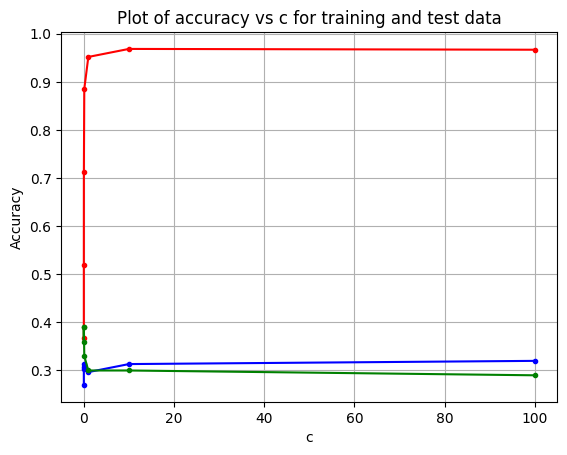

In [47]:
# Run SVM model for different C values
C_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

for c in C_values:
  linear_model_SVM(c)

# Print the results
plt.plot(C_values, train_set_accuracy,'.-',color='red')
plt.plot(C_values, test_set_accuracy,'.-',color='blue')
plt.plot(C_values, val_set_caccuracy,'.-',color='green')
plt.title("Plot of accuracy vs c for training and test data")
plt.xlabel('c')
plt.ylabel('Accuracy')
plt.grid()

In [48]:
# Create a dataframe with the results
results_df = pd.DataFrame(results)
results_df

,Kernel,C,Train Accuracy,Validation Accuracy,Test Accuracy,Run time:
0,linear,0.0001,0.368333,0.39,0.270000,0.053732
1,linear,0.0010,0.518333,0.36,0.313333,0.061530
2,linear,0.0100,0.711667,0.39,0.303333,0.120237
3,linear,0.1000,0.885000,0.33,0.306667,0.852245
4,linear,1.0000,0.951667,0.30,0.296667,7.004843
5,linear,10.0000,0.968333,0.30,0.313333,22.066096
6,linear,100.0000,0.966667,0.29,0.320000,210.102121


Παρατήρησεις:

Εδώ βλέπουμε ότι η ακρίβεια του train set αυξάνεται καθώς αυξάνεται και η τιμή του C (παράγοντας κανονικοποίησης). Αυτό υποδηλώνει ότι το μοντέλο κάνει overfitting, δηλαδή υπερπροσαρμόζεται στα δεδομένα εκπαίδευσης, αλλά αδυνατεί να γενικεύσει με επιτυχία σε νέα δεδομένα. Αυτό φαίνεται στις τιμές των validation και test accuracies, οι οποίες είναι χαμηλές.

SVM RBF Kernel

In [57]:
# Function to train SVM with RBF Kernel
def rbf_model_SVM (C, g):

    start_time = time.time()

    svm_classifier = SVC(kernel='rbf', C=c, gamma=g)

    svm_classifier.fit(X_train, y_train)

    # Accuracy for train set
    pred = svm_classifier.predict(X_train)
    acc_train = np.mean(pred == y_train.ravel())
    train_set_accuracy.append(acc_train)
    print("Train Accuracy for C = {}: {}".format(c, acc_train))

    # Accuracy for validation set
    pred = svm_classifier.predict(X_val)
    acc_val = np.mean(pred == y_val.ravel())
    val_set_accuracy.append(acc_val)
    print("Validation Accuracy for C = {}: {}".format(c, acc_val))

    # Accuracy for test set
    pred = svm_classifier.predict(X_test)
    acc_test = np.mean(pred == y_test.ravel)
    test_set_accuracy.append(acc_test)
    print("Test Accuracy for C = {}: {}".format(c, acc_test))

    # Run time
    end_time = time.time()
    run_time = end_time - start_time

    results.append({
              'Kernel': 'RBF',
              'C': c,
              'Train Accuracy': acc_train,
              'Validation Accuracy': acc_val,
              'Test Accuracy': acc_test,
               'Run time: ': run_time
                  })

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy for C = 0.0001: 0.11333333333333333
Validation Accuracy for C = 0.0001: 0.1
Test Accuracy for C = 0.0001: 0.0
Train Accuracy for C = 0.001: 0.11333333333333333
Validation Accuracy for C = 0.001: 0.1
Test Accuracy for C = 0.001: 0.0
Train Accuracy for C = 0.01: 0.11333333333333333
Validation Accuracy for C = 0.01: 0.1
Test Accuracy for C = 0.01: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy for C = 0.1: 0.11333333333333333
Validation Accuracy for C = 0.1: 0.1
Test Accuracy for C = 0.1: 0.0
Train Accuracy for C = 1: 1.0


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validation Accuracy for C = 1: 0.1
Test Accuracy for C = 1: 0.0
Train Accuracy for C = 10: 1.0
Validation Accuracy for C = 10: 0.1
Test Accuracy for C = 10: 0.0
Train Accuracy for C = 100: 1.0
Validation Accuracy for C = 100: 0.1
Test Accuracy for C = 100: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


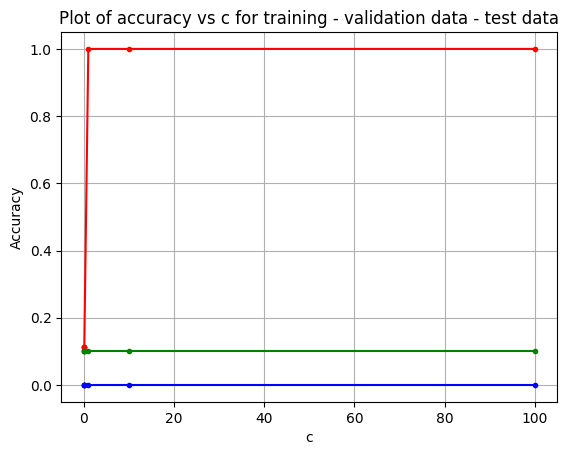

In [60]:
C_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
# C_values =  [0.0001, 0.001, 0.01, 0.1, 1]

# Prepare variables to store the results
train_set_accuracy = []
val_set_accuracy = []
test_set_accuracy = []
results = []

for c in C_values:
  rbf_model_SVM(c, 'auto')

# Print the results
plt.plot(C_values, train_set_accuracy,'.-',color='red')
plt.plot(C_values, test_set_accuracy,'.-',color='blue')
plt.plot(C_values, val_set_accuracy,'.-',color='green')
plt.title("Plot of accuracy vs c for training - validation data - test data")
plt.xlabel('c')
plt.ylabel('Accuracy')
plt.grid()

In [36]:
# Create a dataframe with the results
results_df = pd.DataFrame(results)
results_df

,Kernel,C,Train Accuracy,Validation Accuracy,Test Accuracy,Run time:
0,RBF,0.0001,0.116667,0.09,0.0,0.238420
1,RBF,0.0010,0.116667,0.09,0.0,0.290171
2,RBF,0.0100,0.116667,0.09,0.0,0.295995
3,RBF,0.1000,0.116667,0.09,0.0,0.304551
4,RBF,1.0000,1.000000,0.09,0.0,0.259753
5,RBF,10.0000,1.000000,0.09,0.0,0.278488
6,RBF,100.0000,1.000000,0.09,0.0,0.318346


Polynomial Kernel

In [14]:
# Prepare variables to store the results
train_set_accuracy = []
val_set_caccuracy = []
test_set_accuracy = []
results = []

def poly_model_SVM (C):
      start_time = time.time()
      svm_classifier = SVC(probability= False, kernel='poly', C=c)

      svm_classifier.fit(X_train, y_train)

      # Accuracy for train set
      pred = svm_classifier.predict(X_train)
      acc_train = np.mean(pred == y_train.ravel())
      train_set_accuracy.append(acc_train)
      print("Train Accuracy for C = {}: {}".format(c, acc_train))

      # Accuracy for validation set
      pred = svm_classifier.predict(X_val)
      acc_val = np.mean(pred == y_val.ravel())
      val_set_caccuracy.append(acc_val)
      print("Validation Accuracy for C = {}: {}".format(c, acc_val))

      # Accuracy for test set
      pred = svm_classifier.predict(X_test)
      acc_test = np.mean(pred == y_test.ravel())
      test_set_accuracy.append(acc_test)
      print("Test Accuracy for C = {}: {}".format(c, acc_test))

      # Run time
      end_time = time.time()
      run_time = end_time - start_time

      results.append({
              'Kernel': 'Polynomial',
              'C': c,
              'Train Accuracy': acc_train,
              'Validation Accuracy': acc_val,
              'Test Accuracy': acc_test
                  })

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy for C = 0.0001: 0.11333333333333333
Validation Accuracy for C = 0.0001: 0.1
Test Accuracy for C = 0.0001: 0.08333333333333333
Train Accuracy for C = 0.001: 0.11333333333333333


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validation Accuracy for C = 0.001: 0.1
Test Accuracy for C = 0.001: 0.08333333333333333
Train Accuracy for C = 0.01: 0.11666666666666667
Validation Accuracy for C = 0.01: 0.1
Test Accuracy for C = 0.01: 0.08333333333333333
Train Accuracy for C = 0.1: 0.23166666666666666
Validation Accuracy for C = 0.1: 0.21
Test Accuracy for C = 0.1: 0.12666666666666668


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy for C = 1: 0.6316666666666667
Validation Accuracy for C = 1: 0.28
Test Accuracy for C = 1: 0.2


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy for C = 10: 0.9333333333333333
Validation Accuracy for C = 10: 0.3
Test Accuracy for C = 10: 0.24


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy for C = 100: 0.9933333333333333
Validation Accuracy for C = 100: 0.24
Test Accuracy for C = 100: 0.25333333333333335


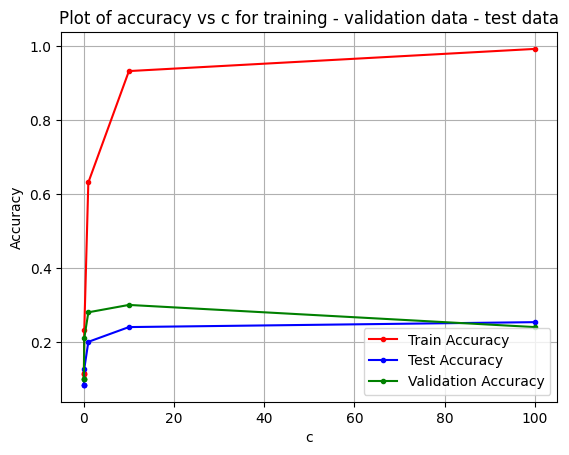

In [66]:
C_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

train_set_accuracy = []
val_set_caccuracy = []
test_set_accuracy = []
results = []
for c in C_values:
  poly_model_SVM(c)

# Print the results
plt.plot(C_values, train_set_accuracy,'.-',color='red')
plt.plot(C_values, test_set_accuracy,'.-',color='blue')
plt.plot(C_values, val_set_caccuracy,'.-',color='green')
plt.legend(['Train Accuracy', 'Test Accuracy', 'Validation Accuracy'])
plt.title("Plot of accuracy vs c for training - validation data - test data")
plt.xlabel('c')
plt.ylabel('Accuracy')
plt.grid()

In [16]:
# Create a dataframe with the results
results_df = pd.DataFrame(results)
results_df

,Kernel,C,Train Accuracy,Validation Accuracy,Test Accuracy
0,Polynomial,0.0001,0.116667,0.09,0.060000
1,Polynomial,0.0010,0.116667,0.09,0.060000
2,Polynomial,0.0100,0.118333,0.09,0.063333
3,Polynomial,0.1000,0.231667,0.19,0.120000
4,Polynomial,1.0000,0.588333,0.24,0.183333
5,Polynomial,10.0000,0.906667,0.17,0.226667
6,Polynomial,100.0000,0.990000,0.21,0.223333


Classifier 2: Grid Search - Cross Validation

In [62]:
# defining parameter range
param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': ['scale', 'auto'],
              'kernel': ['linear', 'rbf', 'poly']}
# svm classifier
svm_classifier2 = SVC()

# grid search
grid_search = GridSearchCV(svm_classifier2, param_grid, cv=10, n_jobs=-1)  # cv=5 για 5-fold cross-validation

# train grid_search
grid_search.fit(X_train, y_train)

# find best parameters of grid search
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [63]:
acc = grid_search.best_score_
print("Best Accuracy:", acc)

Best Accuracy: 0.3383333333333333


Σχόλια για τα διαφορετικά cv = 5 και 10

Εμφανίζουμε μερικές σωστές και λανθασμένες προβλέψεις για το μοντέλο με την καλύτερη απόδοση.

In [ ]:
# create a function that ressembles the image

df plt_img(x):
  nrow = 32
  ncol = 32
  ncolors = 3
  img = x.reshape((nrow, ncol, ncolors)
  plt.imshow(img)
  plt.show()

# plot some correct and error predictions

error_pred = np.where((pred != y_test))[0]
nplt = 8
plt.figure(figuresize=(10,4))

for i in range(nplt):
  plt.subplot(2, nplt, i+1)
  index = error_pred[i]
  plt_img(X_test[index, :])

  title = 'true={0:s} est = {1:s}'.format(classesName[y_test[index]astype(int)],
                                          classesName[pred[index]astype(int)]
                                          plt.title(title))
 plt.tight_layout()
 plt.show()